In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# %cd /content/drive/MyDrive/Colab Notebooks/YEARDREAM/220216_3차 팀 모의 캐글
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/YEARDREAM/220216_3차 팀 모의 캐글/EDA_Data.zip'

In [59]:
!pip install wandb

In [60]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam

import matplotlib.pyplot as plt

import wandb

import warnings
warnings.filterwarnings(action='ignore') 

In [61]:
# 난수 생성기가 항상 일정한 값을 출력하게 하기 위해 seed 고정
random_seed = 2021
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

## EDA

In [62]:
# DATASET_PATH = os.path.join('/workspace/YearDream/task03_time-series_traffic/data')
DATASET_PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/YEARDREAM/220216_3차 팀 모의 캐글/data_2weeks')

In [63]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
train_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247.0,19128.0,2611.0,5161.0,1588.0,892.0,32263.0,1636.0,7938.0,1894.0,14957.0,3527.0,11174.0,2930.0,8640.0,14175.0,2035.0,5231.0,18492.0,48520.0,15393.0,16628.0,8804.0,2790.0,38657.0,1311.0,3482.0,11299.0,7072.0,1176.0,3810.0,748.0,3920.0,2133.0,3799.0
1,20200101,1,89309.0,19027.0,3337.0,5502.0,1650.0,1043.0,35609.0,1644.0,9896.0,1967.0,14682.0,3420.0,13884.0,3062.0,8349.0,15654.0,2417.0,5483.0,15283.0,57904.0,15834.0,19785.0,8483.0,3381.0,45759.0,1162.0,3849.0,13180.0,8771.0,1283.0,3763.0,782.0,3483.0,2057.0,4010.0
2,20200101,2,66611.0,14710.0,2970.0,4631.0,1044.0,921.0,26821.0,1104.0,9343.0,1838.0,11120.0,3587.0,17141.0,3255.0,7025.0,12520.0,1859.0,5058.0,14327.0,53876.0,13866.0,24501.0,8167.0,2670.0,27425.0,768.0,2299.0,7986.0,5426.0,1536.0,3229.0,491.0,2634.0,1526.0,3388.0
3,20200101,3,53290.0,13753.0,2270.0,4242.0,1021.0,790.0,21322.0,909.0,10009.0,1630.0,9836.0,3842.0,20715.0,2661.0,7226.0,9821.0,1724.0,4863.0,12787.0,51615.0,13528.0,28695.0,9459.0,2325.0,18893.0,632.0,1716.0,5703.0,3156.0,1104.0,2882.0,431.0,2488.0,1268.0,3686.0
4,20200101,4,52095.0,17615.0,2406.0,3689.0,1840.0,922.0,22711.0,1354.0,15497.0,1264.0,10668.0,4559.0,28308.0,2894.0,8201.0,9038.0,960.0,5166.0,11479.0,47424.0,18156.0,26977.0,10944.0,3583.0,18135.0,875.0,2421.0,5816.0,2933.0,1206.0,2433.0,499.0,2952.0,1927.0,5608.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,20200517,19,311727.0,101285.0,10085.0,30637.0,10060.0,8749.0,148935.0,6801.0,26101.0,9370.0,74169.0,17764.0,34715.0,19806.0,42734.0,63382.0,14130.0,34866.0,71475.0,96849.0,79150.0,25109.0,14680.0,10465.0,128344.0,6726.0,15431.0,25597.0,14292.0,9300.0,22238.0,3786.0,16936.0,10729.0,20194.0
3308,20200517,20,305354.0,91426.0,8607.0,26021.0,8095.0,7198.0,136503.0,6147.0,20759.0,8432.0,68923.0,14593.0,30279.0,17634.0,37661.0,57815.0,13055.0,31943.0,65378.0,92116.0,72379.0,23165.0,11879.0,9135.0,131682.0,5501.0,15378.0,24661.0,14747.0,8239.0,20604.0,3203.0,15018.0,9767.0,17962.0
3309,20200517,21,306008.0,75113.0,6325.0,19933.0,5711.0,4494.0,129412.0,5134.0,14496.0,6739.0,54455.0,11997.0,27047.0,15943.0,29029.0,54627.0,12292.0,27424.0,60696.0,83628.0,57866.0,16629.0,8573.0,6488.0,127826.0,4216.0,12558.0,22781.0,14081.0,6392.0,17937.0,2447.0,12403.0,7825.0,14031.0
3310,20200517,22,237447.0,49498.0,4209.0,12145.0,3891.0,2718.0,96698.0,3526.0,9363.0,4543.0,35618.0,7996.0,19478.0,10010.0,18663.0,39694.0,8818.0,17770.0,45983.0,57321.0,35250.0,10761.0,5331.0,4109.0,94288.0,2578.0,8870.0,16640.0,11066.0,4427.0,11955.0,1495.0,7507.0,5387.0,8889.0


In [64]:
valid_df = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
valid_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200504,0,108312.0,14342.0,1481.0,3261.0,1133.0,956.0,52934.0,1079.0,2508.0,1751.0,13334.0,3841.0,6604.0,3580.0,6827.0,17190.0,4109.0,6440.0,21884.0,29137.0,12000.0,4624.0,2299.0,1294.0,46185.0,700.0,2674.0,9729.0,5140.0,1948.0,3858.0,391.0,1453.0,1569.0,2405.0
1,20200504,1,59017.0,9235.0,822.0,2030.0,1074.0,667.0,26994.0,702.0,1847.0,1421.0,8717.0,2809.0,4343.0,1857.0,4369.0,8146.0,2408.0,3993.0,13216.0,16320.0,7257.0,2626.0,1479.0,728.0,22403.0,479.0,1709.0,5130.0,3075.0,1270.0,2384.0,243.0,976.0,1096.0,1706.0
2,20200504,2,40926.0,7566.0,703.0,1982.0,655.0,749.0,20098.0,519.0,1461.0,1125.0,6890.0,2504.0,3434.0,1516.0,3923.0,5424.0,1255.0,3497.0,9858.0,12002.0,6004.0,1727.0,1389.0,530.0,14919.0,305.0,1356.0,4141.0,2190.0,1417.0,1968.0,238.0,882.0,947.0,1339.0
3,20200504,3,40942.0,9757.0,826.0,2340.0,685.0,734.0,21219.0,592.0,1734.0,1562.0,8247.0,3062.0,3790.0,1778.0,4381.0,6016.0,1461.0,4598.0,10104.0,12944.0,6795.0,1765.0,1434.0,876.0,15401.0,363.0,1520.0,4551.0,2097.0,1250.0,2175.0,275.0,981.0,989.0,2008.0
4,20200504,4,72762.0,16698.0,1557.0,4147.0,1267.0,948.0,34612.0,874.0,2379.0,2013.0,10862.0,4239.0,5178.0,2805.0,6775.0,12833.0,3186.0,7842.0,14838.0,25759.0,11482.0,2885.0,2296.0,1393.0,31577.0,652.0,2408.0,8770.0,3707.0,1667.0,4004.0,517.0,1960.0,1691.0,3589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,20200524,19,314226.0,98345.0,10625.0,28618.0,8316.0,6684.0,141675.0,6619.0,23535.0,8572.0,67748.0,16791.0,33325.0,19124.0,42183.0,63229.0,13163.0,35383.0,73188.0,100849.0,84286.0,26458.0,15572.0,10341.0,139827.0,8254.0,16118.0,23304.0,14082.0,8447.0,21694.0,2180.0,15746.0,10903.0,21014.0
500,20200524,20,300001.0,87871.0,8226.0,22706.0,6981.0,5743.0,142933.0,6295.0,20953.0,7851.0,61609.0,14119.0,30216.0,18610.0,35556.0,59070.0,12788.0,30675.0,68255.0,95107.0,76441.0,24140.0,13340.0,8872.0,142469.0,5225.0,15297.0,21919.0,14526.0,7332.0,19732.0,1990.0,14096.0,10028.0,17787.0
501,20200524,21,304150.0,71126.0,6002.0,18317.0,4939.0,3779.0,133110.0,4781.0,15242.0,6101.0,48336.0,11534.0,25710.0,15651.0,27467.0,53787.0,12019.0,26317.0,61169.0,86434.0,61136.0,21076.0,9317.0,6392.0,138816.0,4072.0,12685.0,21135.0,14403.0,5443.0,16967.0,1359.0,11670.0,7963.0,14041.0
502,20200524,22,236751.0,44947.0,3575.0,11455.0,3135.0,2536.0,98582.0,3267.0,8849.0,4553.0,33607.0,8069.0,18293.0,9723.0,16602.0,38615.0,8703.0,17694.0,47609.0,58492.0,37501.0,12090.0,5901.0,3938.0,100767.0,2489.0,8093.0,14427.0,10914.0,3861.0,11397.0,859.0,7270.0,5194.0,8230.0


In [65]:
test_df = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))
test_df

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200511,0,77968.0,14429.0,1233.0,4021.0,981.0,881.0,28672.0,1064.0,2859.0,1549.0,12036.0,3225.0,7324.0,2789.0,5907.0,11097.0,2641.0,5396.0,20709.0,20787.0,8429.0,3184.0,2055.0,1430.0,27798.0,637.0,2604.0,5239.0,4168.0,1155.0,3596.0,337.0,2262.0,1608.0,2337.0
1,20200511,1,48679.0,9136.0,823.0,2618.0,654.0,572.0,17722.0,672.0,1940.0,1133.0,8316.0,2096.0,4423.0,1778.0,4028.0,7105.0,1773.0,3532.0,13160.0,13035.0,5459.0,1741.0,1230.0,859.0,16145.0,353.0,1870.0,3359.0,2558.0,1002.0,2157.0,257.0,1425.0,1018.0,1810.0
2,20200511,2,33773.0,8199.0,578.0,2188.0,392.0,502.0,14464.0,579.0,1425.0,1211.0,6623.0,2168.0,3693.0,1642.0,3376.0,5290.0,1268.0,3085.0,10377.0,10477.0,4610.0,1070.0,967.0,752.0,12335.0,345.0,1499.0,2646.0,2022.0,876.0,1959.0,232.0,1155.0,927.0,1530.0
3,20200511,3,41511.0,9986.0,726.0,2817.0,555.0,646.0,17793.0,650.0,1678.0,1748.0,7857.0,2593.0,4378.0,1637.0,4389.0,6325.0,1642.0,3983.0,11258.0,13014.0,5047.0,1289.0,1028.0,1129.0,14189.0,390.0,1730.0,3398.0,1967.0,912.0,2462.0,281.0,1477.0,959.0,1882.0
4,20200511,4,78680.0,19509.0,1463.0,4720.0,825.0,1088.0,35125.0,997.0,2531.0,2304.0,12197.0,4013.0,7034.0,3207.0,6514.0,13898.0,3185.0,8286.0,18038.0,27303.0,9132.0,2202.0,1599.0,1609.0,32976.0,679.0,2958.0,7369.0,4120.0,1569.0,4568.0,577.0,3155.0,1871.0,3656.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,20200531,19,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
500,20200531,20,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
501,20200531,21,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
502,20200531,22,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [66]:
train_df.iloc[:,[0, 1, 3]]

,날짜,시간,100
0,20200101,0,19128.0
1,20200101,1,19027.0
2,20200101,2,14710.0
3,20200101,3,13753.0
4,20200101,4,17615.0
...,...,...,...
3307,20200517,19,101285.0
3308,20200517,20,91426.0
3309,20200517,21,75113.0
3310,20200517,22,49498.0


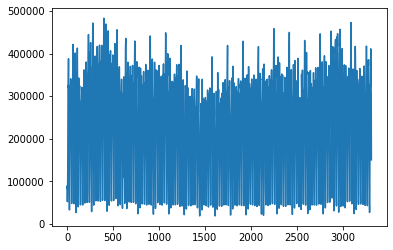

In [67]:
train_df['10'].plot()

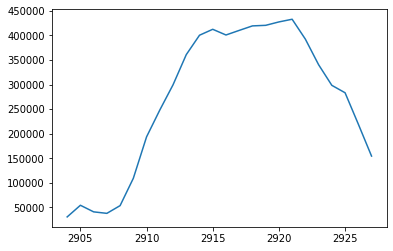

In [68]:
train_df['10'][train_df['날짜']==20200501].plot()

## Dataloader
* 한 칼럼에 대한 7일(168행) 데이터를 input_data, 뒤따르는 7일 데이터를 output_data로 반환합니다.
* 도로별 차이를 두지 않고 모든 도로를 동일한 타입의 데이터로 취급합니다.
* 모든 csv 파일의 마지막 168행은 예측해야하는 값이므로 input으로 들어가지 않습니다.

In [69]:
class CustomDataset(data.Dataset):      # torch.utils.data.Dataset 클래스의 상속 클래스 CustomDataset 클래스 생성. 상속 클래스 생성시 __init__, __getitem__, __len__함수는 기본적으로 정의해줘야 함.
    
    def __init__(self, root, seq_len, batch_size=64, phase='train'):      # 데이터 로드 단계에 사용될 여러 변수들을 'self.변수명'의 형태로 지정해두는 함수
        
        self.root = root      # CustomDataset 객체 생성 시 데이터 경로 앞부분(공통 부분)을 root로 입력받아 저장
        self.phase = phase      # CustomDataset 객체 생성 시 데이터 경로 뒷부분(train/validate/test)을 phase로 입력받아 저장
        self.label_path = os.path.join(self.root, self.phase + '.csv')      # 데이터 전체 경로 생성
        df = pd.read_csv(self.label_path)      # 생성한 데이터 전체 경로로부터 데이터 로드
        
        self.seq_len = seq_len * 24      # 일 단위 기간을 입력 받은 후 시간 단위 기간으로 변환하여 저장
        self.batch_size = batch_size
        self.labels = {}
        
        timestamps = [(i, j) for (i, j) in zip(list(df['날짜']), list(df['시간']))]      # 날짜와 시간 정보가 튜플로 들어 있는 리스트 생성
        categories = df.columns.values.tolist()[2:]      # 도로명 column list 생성

        input_data = []
        output_data = []

        for t in range(len(timestamps)):
            temp_input_data = []
            temp_output_data = []
            for col in categories:
                road = df[col].tolist()
                inp = [float(i) for i in road[t:t+self.seq_len]]      # input 데이터 시계열 구간 설정
                # outp = [float(j) for j in road[t+self.seq_len:t+int(2*self.seq_len)]]      # output 데이터 시계열 구간 설정(1주 -> 1주 예측)
                outp = [float(j) for j in road[t+self.seq_len:t+int(1.5*self.seq_len)]]      # output 데이터 시계열 구간 설정(2주 -> 1주 예측)
                # outp = [float(j) for j in road[t+self.seq_len:t+int((1+1/4)*self.seq_len)]]      # output 데이터 시계열 구간 설정(4주 -> 1주 예측)
                temp_input_data.append(inp) 
                temp_output_data.append(outp)
            input_data.append(temp_input_data)
            output_data.append(temp_output_data)
            
# input_data : [[첫번째 input 기간 동안의 첫번째 도로의 통행량 list, ..., 첫번째 input 기간 동안의 35번째 도로의 통행량 list], ...,
#               [마지막 input 기간 동안의 첫번째 도로의 통행량 list, ..., 마지막 input 기간 동안의 35번째 도로의 통행량 list]]
# output_data : [[첫번째 output 기간 동안의 첫번째 도로의 통행량 list, ..., 첫번째 output 기간 동안의 35번째 도로의 통행량 list], ...,
#                [마지막 output 기간 동안의 첫번째 도로의 통행량 list, ..., 마지막 output 기간 동안의 35번째 도로의 통행량 list]]
        
        self.labels['timestamp'] = timestamps
        self.labels['category'] = categories
        self.labels['input'] = input_data
        self.labels['output'] = output_data

    def __getitem__(self, index):      # index를 가지고 데이터를 하나씩 불러올 수 있게 하는 함수

#         데이터 내 index가 부여되는 형태

#                 | road_1    road_2    ...  road_35
#                -------------------------------------
#         time_1  | index_0   index_1   ...  index_34
#         time_2  | index_35  index_36  ...  index_69

        row = index // 35      # index를 35(도로수)로 나눈 몫  ex) 71//35 -> 2
        col = index % 35      # index를 35(도로수)로 나눈 나머지  ex) 71%35 -> 1

        timestamp = self.labels['timestamp'][row]      # (날짜, 시간) 튜플이 들어있는 list에서 row번째 시점에 해당하는 튜플
        category = self.labels['category'][col]      # 도로명 column list에서 col번째 도로에 해당하는 element
        
        input_data = torch.tensor(self.labels['input'][row][col])      # input_data list에서, row번째 시점의 col번째 도로 교통량 정보

        if self.phase != 'test':
            output_data = torch.tensor(self.labels['output'][row][col])
        else:
            output_data = []

        return timestamp, category, (input_data, output_data)

    def __len__(self):      # getitem 함수를 통해 데이터를 불러오려면,전체 index 길이를 알아야 한다.
        # return (len(self.labels['timestamp']) - int(self.seq_len * 2) + 1) * 35      # 특정 시점이 아닌 특정 기간을 하나의 data 단위로 설정하면, 전체 샘플 수는 감소함을 반영(1주 -> 1주 예측) 
        return (len(self.labels['timestamp']) - int(self.seq_len * 1.5) + 1) * 35      # 특정 시점이 아닌 특정 기간을 하나의 data 단위로 설정하면, 전체 샘플 수는 감소함을 반영(2주 -> 1주 예측)
        # return (len(self.labels['timestamp']) - int(self.seq_len * (1+1/4)) + 1) * 35      # 특정 시점이 아닌 특정 기간을 하나의 data 단위로 설정하면, 전체 샘플 수는 감소함을 반영(4주 -> 1주 예측)


def data_loader(root, phase='train', batch_size=64, seq_len=7, drop_last=False):
    if phase == 'train':
        shuffle = True
    else:
        shuffle = False

    dataset = CustomDataset(root, seq_len, batch_size, phase)
    dataloader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

    return dataloader

## Model

### N-Beats

In [70]:
class NBeatsNet(nn.Module):
    def __init__(self,
                 forecast_length=168,
                 backcast_length=168,
                 theta_dim=(1, 3, 3),
                 n_trend=3,
                 n_seasonality=3,
                 n_residual=3,
                 hidden_dim=512,
                 feature_dim=1):
        super(NBeatsNet, self).__init__()        
            
        self.trend_stack = []
        self.seasonality_stack = []
        self.residual_stack = [] #bs =[] 이건했는데 fs=[] 이거 안해줌
        
        for i in range(n_trend):
            self.trend_stack.append(Block(backcast_length, forecast_length, hidden_dim, theta_dim[0], mode='trend', feature_dim=feature_dim))    

        for i in range(n_seasonality):
            self.seasonality_stack.append(Block(backcast_length, forecast_length, hidden_dim, theta_dim[1], mode='seasonality', feature_dim=feature_dim))
        
        for i in range(n_residual):
            self.residual_stack.append(Block(backcast_length, forecast_length, hidden_dim, theta_dim[2], mode='residual', feature_dim=feature_dim))
        
        
        self.trend_stack = nn.ModuleList(self.trend_stack)
        self.seasonality_stack = nn.ModuleList(self.seasonality_stack)
        self.residual_stack = nn.ModuleList(self.residual_stack)

    def forward(self, backcast):
        backcast_stack = []
        forecast_stack = []

        for layer in self.trend_stack:
            b, f = layer(backcast)
            backcast_stack.append(b)
            forecast_stack.append(f)
            backcast = backcast - b

        for layer in self.seasonality_stack:
            b, f = layer(backcast)
            backcast_stack.append(b)
            forecast_stack.append(f)
            backcast = backcast - b

        for layer in self.residual_stack:
            b, f = layer(backcast)
            backcast_stack.append(b)
            forecast_stack.append(f)
            backcast = backcast - b

        backcast = torch.stack(backcast_stack, 0)
        forecast = torch.stack(forecast_stack, 0)
        return backcast, forecast


# ours
class Block(nn.Module):
    def __init__(self, backcast_length, forecast_length, hidden_dim, theta_dim, mode, feature_dim):
        super(Block, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.theta_dim = theta_dim
        self.mode = mode

        self.MLP = nn.Sequential(
                nn.Linear(backcast_length * feature_dim, hidden_dim), 
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU()
            ) # univariate??multivariate??

        if mode == 'residual':
            # residual  
            self.theta_b = nn.Linear(hidden_dim, theta_dim * feature_dim)             
            self.theta_f = nn.Linear(hidden_dim, theta_dim * feature_dim)
            self.linear_b = nn.Linear(theta_dim, backcast_length)
            self.linear_f = nn.Linear(theta_dim, forecast_length)
        else:
            # trend, seasonality
            self.theta = nn.Linear(hidden_dim, theta_dim*feature_dim)


    def forward(self, x):
        shape = x.shape
        # x: (batch size, backcast length, feature_dim)
        t_b = ((torch.arange(start=0, end=self.backcast_length, device=x.device, dtype=torch.float) - self.backcast_length) / 24 ) # (backcast_len,)
        t_f = ((torch.arange(start=0, end=self.forecast_length, device=x.device, dtype=torch.float)) / 24 ) # (forecast_len,)

        # x -> h
        x = self.MLP(x.reshape(x.shape[0], -1)) # (batch, backcast length * feature_dim) -> (batch, hidden_dim)

        # h -> theta -> backcast, forecast
        if self.mode == 'residual':
            # residual block
            theta_b = self.theta_b(x).reshape(shape[0], shape[2], self.theta_dim)
            theta_f = self.theta_f(x).reshape(shape[0], shape[2], self.theta_dim)
            b = self.linear_b(theta_b).permute(0,2,1) # (batch, backcast length, feature_dim)
            f = self.linear_f(theta_f).permute(0,2,1) # (batch, forecast length, feature_dim)
        else:
            theta_b = self.theta(x).reshape(shape[0], self.theta_dim, shape[2])
            theta_f = theta_b

            if self.mode == 'trend':
                b = self.get_trend(theta_b, t_b)
                f = self.get_trend(theta_f, t_f)
                
            elif self.mode == 'seasonality':
                b = self.get_seasonality(theta_b, t_b)
                f = self.get_seasonality(theta_f, t_f)
        return b, f

    def get_trend(self, theta, t):
        # theta dim = 0 -> 수평선 (y=a)
        # theta dim = 1 -> 직선 (y=bx)
        # theta dim = 2 -> 이차곡선 (y=cx^2)
        # ...
        # T = [t^0=1, t, t^2, t^3, ...], theta = [a, b, c, d, ...] -> y = a + bt + ct^2 + dt^3 + ...
        T = torch.stack([t ** i for i in range(theta.shape[1])])  # (theta_dim ,sequence length) -> btf
        out = torch.einsum('btf,ts->bsf', theta, T)  # (theta_dim, sequence_length) -> ts
        return out  # (batch, sequence_length, feature_dim) -> bsf


    def get_seasonality(self, theta, t):
        s1 = torch.stack([torch.cos(2 * np.pi * (i+1) * t) for i in range(self.theta_dim//2)]).float()  # H/2-1
        s2 = torch.stack([torch.sin(2 * np.pi * (i+1) * t) for i in range(self.theta_dim//2)]).float()
        S = torch.cat([s1, s2])
        out = torch.einsum('btf,ts->bsf', theta, S)
        return out

In [71]:
# 결과 파일과 모델 가중치 파일 저장을 위해 log 디렉토리 생성. 중요한 파일이 덮어씌워지지 않도록 주의
os.makedirs('log', exist_ok=True)      # log 폴더 생성, 이미 생성되었을 시 추가로 생성하지 않도록 exist_ok=True


def save_model(model_name, model, optimizer):      # 모델 가중치 파일 저장 함수
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, os.path.join('/content/drive/MyDrive/Colab Notebooks/YEARDREAM/220216_3차 팀 모의 캐글/log', model_name + '.pth'))
    print('model saved\n')


def load_model(model_name, model, optimizer=None):      # 모델 가중치 파일 로드 함수
    state = torch.load(os.path.join('/content/drive/MyDrive/Colab Notebooks/YEARDREAM/220216_3차 팀 모의 캐글/log', model_name))
    model.load_state_dict(state['model'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optimizer'])
    print('model loaded')

## Hyperparameters

In [72]:
dtype = torch.float
num_epochs = 30
base_lr = 11e-5  #0.01
seq_len = 7 * 2

# input_size = seq_len * 24
# hidden_size = 1024
# output_size = input_size // 2
batch_size = 64
# num_layers = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training Setting

In [73]:
# model hyper parameters
theta_dim=(2, 10, 3)  # (2, 8, 3)
n_trend=5
n_seasonality=5
n_residual=20
hidden_dim=1024
forecast_length = 24 * 7
backcast_length = 24 * 7 * 2
feature_dim = 1

model = NBeatsNet(forecast_length, backcast_length, theta_dim, n_trend, n_seasonality, n_residual, hidden_dim, feature_dim)
model = model.to(device)

# loss function
criterion = nn.MSELoss()      # 플랫폼 상 채점은 RMSE, 즉 MSE에 root를 씌운 값이기 때문에 사실상 평가지표와 같은 Loss입니다.

# optimizer
optimizer = Adam(model.parameters(), lr=base_lr)      # optimizer로는 Adam이 가장 무난합니다. Adam을 쓰면 learning_rate를 따로 지정해주지 않아도 알아서 조정됩니다.

In [74]:
model

NBeatsNet(
  (trend_stack): ModuleList(
    (0): Block(
      (MLP): Sequential(
        (0): Linear(in_features=336, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=1024, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1024, out_features=1024, bias=True)
        (5): ReLU()
        (6): Linear(in_features=1024, out_features=1024, bias=True)
        (7): ReLU()
      )
      (theta): Linear(in_features=1024, out_features=2, bias=True)
    )
    (1): Block(
      (MLP): Sequential(
        (0): Linear(in_features=336, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=1024, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1024, out_features=1024, bias=True)
        (5): ReLU()
        (6): Linear(in_features=1024, out_features=1024, bias=True)
        (7): ReLU()
      )
      (theta): Linear(in_features=1024, out_features=2, bias=True)
    )
    (2): Block

In [75]:
# get data loader
train_dataloader = data_loader(root=DATASET_PATH,
                               phase='train',
                               batch_size=batch_size,
                               seq_len=seq_len,
                               drop_last=True)

validate_dataloader = data_loader(root=DATASET_PATH,
                                  phase='validate',
                                  batch_size=1,
                                  seq_len=seq_len,
                                  drop_last=True)

In [76]:
len(validate_dataloader)

35

In [77]:
# a = 0
# for i in validate_dataloader:
#     print(i)
#     a += 1
#     if a > 5: break

## Train

In [78]:
train_batch_loss = 0.0      # 400 batch마다 평균 training loss를 확인한 다음, train_batch_loss를 0으로 갱신해줄 것
train_epoch_loss = 0.0      # 1 epoch마다 평균 training loss를 확인한 다음, train_epoch_loss를 0으로 갱신해줄 것

valid_epoch_loss = 0.0      # 1 epoch마다 평균 validation loss를 확인한 다음, valid_epoch_loss를 0으로 갱신해줄 것
valid_min_epoch_loss = np.inf      # 초기 loss를 마이너스 무한대로 설정해두고, validation epoch loss가 낮아질 때마다 갱신해줄 것

# Wandb 기록
wandb.init(project='Traffic Time Series Forecasting', entity='seongjin_ahn', name='N-BEATS rm outliers(2) & back=2 & n=5,5,20 & lr=1.1e-4 & 2,8,3')
wandb.watch(model, criterion, log='all', log_freq=10)

# Early Stop(일정 에포크 이상 valid loss가 개선되지 않으면 학습 정지)
early_stop_count = 0
max_early_stop = 5

for epoch in range(num_epochs):

    model.train()      # 모델을 train mode로 전환. train mode일 때만 적용되어야 하는 drop out 등이 적용될 수 있게 하기 위함 

    for iter_, sample in enumerate(train_dataloader):      # enumerate 함수를 통해 train_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출
        _, _, (input_data, output_data) = sample      # train_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨.
                                                      # 학습에는 [[input_data], [output_data]]만 사용
        
        input_data = input_data.unsqueeze(2).to(device)
        output_data = output_data.unsqueeze(2).to(device)

        back_pred, fore_pred = model(input_data)
        
        loss = criterion(back_pred.sum(0), input_data) + criterion(fore_pred.sum(0), output_data)

        model.zero_grad()    # 파라미터 업데이트는 batch 단위로 이루어지고, 매 batch마다 gradient를 초기화해주어야 함 
        # optimizer.zero_grad()    # 파라미터 업데이트는 batch 단위로 이루어지고, 매 batch마다 gradient를 초기화해주어야 함 
        loss.backward()      # backpropagation
        optimizer.step()      # 파라미터 업데이트
        
        train_batch_loss += loss.item()
        train_epoch_loss += loss.item()

        if iter_ % 400 == 399:      # 400개의 batch마다 training Loss 출력
            print('Train Epoch: {:2} | Batch: {:4} | Loss: {:1.2f}'.format(epoch, iter_+1, train_batch_loss/400))
            train_batch_loss = 0
            
    wandb.log({'Epoch': epoch, 'train_loss': train_epoch_loss})
    train_epoch_loss = 0.0      # training epoch마다 train_epoch_loss 새로 구해줄 것

    
    model.eval()      # 모델을 eval mode로 전환. eval mode에서 적용되면 안되는 drop out 등이 적용되지 않게 하기 위함

    with torch.no_grad():      # validation / test set에 대해서는 weight 및 bias의 update, 즉, gradient descent가 일어나지 않도록 no_grad()를 선언
        for iter_, sample in enumerate(validate_dataloader):      # enumerate 함수를 통해 validate_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

            _, _, (input_data, output_data) = sample      # validate_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨. validation에는 [[input_data], [output_data]]만 사용

            input_data = input_data.unsqueeze(2).to(device)
            output_data = output_data.unsqueeze(2).to(device)

            back_pred, fore_pred = model(input_data)
            loss = criterion(back_pred.sum(0), input_data) + criterion(fore_pred.sum(0), output_data)
            valid_epoch_loss += loss.item()

        print('\nValid Epoch: {:2} | Loss: {:1.2f}'.format(epoch, valid_epoch_loss/len(validate_dataloader)))

        if valid_epoch_loss < valid_min_epoch_loss:
            save_model('n_beats_rm_outliers_best', model, optimizer)
            valid_min_epoch_loss = valid_epoch_loss
            early_stop_count = 0
        elif valid_epoch_loss > valid_min_epoch_loss:
            early_stop_count += 1
            print('\n------------- early stop: {}/{} -------------\n'.format(early_stop_count, max_early_stop))
            if early_stop_count == max_early_stop:
                break

        wandb.log({'valid_loss': valid_epoch_loss})
        valid_epoch_loss = 0.0

Train Epoch:  0 | Batch:  400 | Loss: 282034051.32
Train Epoch:  0 | Batch:  800 | Loss: 163202282.39
Train Epoch:  0 | Batch: 1200 | Loss: 152133353.00

Valid Epoch:  0 | Loss: 130707863.46
model saved

Train Epoch:  1 | Batch:  400 | Loss: 255185850.79
Train Epoch:  1 | Batch:  800 | Loss: 125991200.86
Train Epoch:  1 | Batch: 1200 | Loss: 118388376.26

Valid Epoch:  1 | Loss: 109238925.45
model saved

Train Epoch:  2 | Batch:  400 | Loss: 195570048.78
Train Epoch:  2 | Batch:  800 | Loss: 99747541.49
Train Epoch:  2 | Batch: 1200 | Loss: 96947486.65

Valid Epoch:  2 | Loss: 93266102.96
model saved

Train Epoch:  3 | Batch:  400 | Loss: 163616784.42
Train Epoch:  3 | Batch:  800 | Loss: 85297660.80
Train Epoch:  3 | Batch: 1200 | Loss: 79220984.44

Valid Epoch:  3 | Loss: 89506508.09
model saved

Train Epoch:  4 | Batch:  400 | Loss: 144066365.08
Train Epoch:  4 | Batch:  800 | Loss: 71511662.22
Train Epoch:  4 | Batch: 1200 | Loss: 70326154.08

Valid Epoch:  4 | Loss: 86611979.53
mo

In [79]:
wandb.finish()

Epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▃▁▁▁▃▂▁▂▁▂▂
Epoch,28
train_loss,33846473178.0
valid_loss,2251580198.8125


## Inference

In [80]:
dtype = torch.float
seq_len = 7 * 2

# input_size = seq_len * 24
hidden_size = 1024
# output_size = input_size
batch_size = 1
# num_layers = 6

In [81]:
test_dataloader = data_loader(root=DATASET_PATH,
                              phase='test',
                              batch_size=batch_size,
                              seq_len=seq_len,
                              drop_last=True)

In [82]:
# model = LSTMNet(input_size=input_size,
#                 hidden_size=hidden_size,
#                 output_size=output_size,
#                 batch_size=batch_size,
#                 num_layers=num_layers)
theta_dim=(2, 10, 3)
# theta_dim=(4, 12, 4)
n_trend=5
n_seasonality=5
n_residual=20
hidden_dim=1024
forecast_length = 24 * 7
backcast_length = 24 * 7 * 2
feature_dim = 1

model = NBeatsNet(forecast_length, backcast_length, theta_dim, n_trend, n_seasonality, n_residual, hidden_dim, feature_dim)

# model
model_name = 'n_beats_rm_outliers_best.pth'

load_model(model_name, model)
model = model.to(device)

model loaded


In [83]:
submission_file_path = os.path.join(DATASET_PATH, 'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)

In [84]:
# (h_in, c_in) = (torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device),
#                 torch.zeros(num_layers, 1, hidden_size, requires_grad=False).to(device))
for iter_, sample in enumerate(test_dataloader):

    timestamp, category, (input_data, output_data) = sample
    input_data = input_data.unsqueeze(2).to(device)

    back_pred, fore_pred = model(input_data)

    for i, (t, h) in enumerate(zip(timestamp[0], timestamp[1])):
        for cat, row in zip(category, fore_pred.sum(0)):
            cat = f'{cat}'
            new_row = row.resize(row.size()[0])
            submission_table[cat] = new_row.tolist()

In [85]:
submission_table

,timestamp,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,82395.296875,16284.305664,2791.827881,3856.307129,1406.830688,1176.399170,36138.812500,961.503662,1874.813232,1977.890747,12170.162109,3770.699707,7215.432129,4555.727051,5781.376953,13899.974609,3723.562988,7236.373535,19034.878906,22702.634766,11033.418945,2615.090332,1391.327148,1296.951904,37071.242188,820.977295,2258.379883,4559.465820,4766.698242,1418.339722,3713.787598,173.258942,2212.927734,1501.649902,2272.942383
1,20200525_1,55483.195312,11116.844727,1760.461426,2913.507568,841.727295,640.506958,27253.472656,715.761536,939.020386,1632.343872,8442.076172,2553.748291,5692.603516,3146.582031,4285.028320,9513.894531,2698.355469,5701.807129,14240.851562,17372.671875,7044.698242,1902.088623,723.600952,752.779297,20349.953125,456.804138,1626.923828,1390.822266,2479.593262,1021.760864,2938.875977,-55.207115,1582.439941,878.923706,1575.797485
2,20200525_2,45196.757812,6444.834961,598.132141,1742.641479,-348.217834,-1.759674,24642.154297,374.063049,318.004578,1610.310791,4024.137695,824.749268,5573.721191,3533.996094,3115.537842,8739.065430,2413.414551,4943.629883,11812.558594,14261.896484,4120.712891,1209.877808,367.850952,375.422913,16199.063477,-102.466125,1163.964600,-684.448730,1261.075684,669.525757,2093.240967,-427.447327,422.250122,-71.469238,599.318848
3,20200525_3,56626.515625,11940.578125,1085.358887,4162.225586,292.750000,563.548401,26315.492188,579.475769,1829.281006,2175.661133,7659.897461,3215.088867,6763.489746,4492.568848,5320.941895,9426.842773,2428.429443,6975.860352,14219.257812,14426.350586,9417.970703,2503.429199,1636.792603,917.264282,18317.095703,581.655579,1585.942871,693.738281,1686.423950,971.783936,3157.367432,-374.068481,2155.147461,844.141479,1375.388916
4,20200525_4,106145.359375,21508.363281,1942.119385,7295.380859,1469.091431,1374.950439,45961.687500,1091.910889,4269.021973,2825.852783,13287.083984,4689.877930,8858.661133,5288.224609,7888.164062,19707.509766,4899.667969,12561.881836,21486.382812,29866.101562,16740.562500,5580.549316,3406.921875,1734.471436,51570.078125,779.801941,3524.017334,8612.177734,5780.841309,1806.897949,5521.579102,106.771423,3879.526367,2280.427246,3615.588623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,300348.750000,84008.773438,8828.029297,26149.263672,8656.731445,7080.728027,137180.062500,5933.113281,22389.939453,8467.192383,64332.562500,17363.533203,31148.468750,17476.529297,40935.855469,60507.593750,12161.725586,33831.730469,69766.210938,92833.570312,66154.296875,21427.039062,11818.271484,8164.331055,124702.210938,6766.145996,13700.747070,24183.343750,14383.914062,8132.886230,21570.593750,2136.263672,14138.125000,9370.235352,17249.160156
164,20200531_20,276100.312500,71049.203125,6013.002930,20201.708984,5774.774414,4620.879395,123711.820312,5001.731934,18234.853516,7084.303223,53423.492188,14394.872070,26432.935547,14187.304688,33689.007812,52432.992188,10748.403320,28035.986328,62433.679688,81055.000000,58342.910156,17790.431641,9002.135742,6609.600098,116329.078125,5054.977539,12635.782227,22425.763672,12757.330078,6740.019043,17363.486328,1230.134766,11679.060547,7536.043457,13210.490234
165,20200531_21,263474.750000,64626.160156,5337.255859,16486.953125,5483.420898,3725.320557,117834.554688,4473.788574,14875.486328,5937.781250,49180.316406,12591.469727,22606.539062,12835.375000,28035.667969,48547.488281,9904.311523,24269.230469,53625.179688,75172.414062,48358.765625,15880.312500,8053.115723,5563.580566,113449.515625,4253.313477,11634.998047,20838.003906,13713.912109,5285.031250,15496.921875,1249.220703,10594.364258,7099.610840,11980.807617
166,20200531_22,226771.578125,43765.714844,3532.595459,10682.139648,3947.616211,2501.769043,94368.007812,3115.160645,9448.252930,4484.

In [86]:
# submission_table.to_csv('prediction.csv', index=False)
submission_table.to_csv('/content/drive/MyDrive/Colab Notebooks/YEARDREAM/220216_3차 팀 모의 캐글/predictions/prediction_25_n_beats_ro_b2_n5_5_20_lr11e5_2_8_3.csv', index=False)